In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
stemmer= PorterStemmer() # create the instance

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.sentiment import SentimentIntensityAnalyzer
SIA= SentimentIntensityAnalyzer() # create the instance

[nltk_data] Downloading package punkt to C:\Users\hchih...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\hchih...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# get dialogue dataframe
def get_dialogue(script):
    raw= []    
    if '#' in script[0]:
        for n, para in enumerate(script):
                if '#' in para: pass
                else: raw.append(para)                    
    else: 
        for n, para in enumerate(script):
                dp= []
                for i, ele in enumerate(para):
                    if ele== '[': 
                            dp.append(i-1) 
                    elif ele== ']': 
                            dp.append(i+2)
                if (len(dp)== 0):
                    if len(para)== 1: # no content no [] 
                        pass
                    else: 
                        raw.append(para) # content with no [] 
                elif (len(dp)!= 0) and (dp[0]== -1):
                    pass
                else:
                    for i in range(len(dp), 0, -2):
                        para= para.replace(para[dp[i-2]:dp[i-1]-1],' ')
                    raw.append(para)
    return raw

In [3]:
# turn to dataframe 
def to_df(scripts):    
    # seperate character & lines, save to dataframe
    chct_lst= []
    ln_lst=[]    
    for i, script in enumerate(scripts):
            for n, para in enumerate(script):             
                para= para.lower().replace('\n',' ')
                if len(para.split(':'))== 2:
                    chct= para.split(':', 1)[0]
                    chct_lst.append(chct)
                    line= para.split(':', 1)[1]
                    ln_lst.append(line)
    df= pd.concat([pd.DataFrame({'Character': chct_lst}),
                pd.DataFrame({'Line': ln_lst})], axis= 1)
    
    # name integration
    df['Character'].replace({'iron man': 'tony stark', 'tony': 'tony stark',
                    'natasha': 'natasha romanoff', 'black widow': 'natasha romanoff', 
                    'captain america': 'steve rogers', 'steve': 'steve rogers',
                    'james barnes': 'bucky barnes', 'winter soldier': 'bucky barnes', 
                    'hawkeye': 'clint barton', 'clint': 'clint barton',
                    'bruce': 'bruce banner', 'hulk': 'bruce banner',
                    't\'challa': 'black panther',
                    'fury': 'nick fury',
                    'peter parker': 'spider man', 'rocket raccoon': 'rocket',
                    'scott': 'scott lang', 
                    'carol': 'captain marvel',
                    'dr. strange': 'dr strange', 'dr. stephen strange': 'dr strange', 'doctor stephen strange': 'dr strange', 'doctor strange': 'dr strange',
                    'pepper': 'pepper potts'
                         }, inplace= True)
    return df

In [4]:
# clean dialogue with nltk
def get_cleandf(df):
    tknzr= RegexpTokenizer('\w+')

    # tokenize & count
    df.insert(2, column='Line Clean', value= df['Line'].apply(lambda para: ' '.join(sent_tokenize(para))))
    df.insert(3, column='Line Count', value= df['Line'].apply(lambda para: len(sent_tokenize(para)) ))
    df.insert(4, column='Word Count', value= df['Line'].apply(lambda para: len(para.split())))
    
    # remove punctuation, remove stopword, stem
    df['Line Clean']= df['Line Clean'].apply(lambda para: ' '.join(tknzr.tokenize(para)))\
    .apply(lambda para: ' '.join(word for word in para.split() if word not in stopwords.words('english')))\
    .apply(lambda para: ' '.join(stemmer.stem(word) for word in para.split()))
    
    df.insert(5, column="Sentiment Score", value= df['Line Clean'].apply(lambda sent: SIA.polarity_scores(sent)['compound']))

    return df

In [5]:
# set main characters statistics and generate plot
def to_plot(df):
    global main_char
    mvchar_group= df[df['Character'].isin(main_char)].groupby('Character')
    
    fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
    mvchar_group['Line Count'].sum().sort_values().plot\
    (kind='barh', title= 'Line Count of Main Character', figsize= (10, 18), color= 'gold', ax= ax)
    mvchar_group['Word Count'].sum().sort_values().plot\
    (kind='barh', title= 'Word Count of Main Character', figsize= (10, 18), color= 'lightblue', ax= ax2)
    mvchar_group['Sentiment Score'].mean().sort_values().\
    plot(kind='barh', title= 'Avarage Sentiment of Main Character', figsize= (10, 18), color= 'aquamarine', ax= ax3)
    fig.tight_layout() # adjust subplot automatically

In [6]:
# generate wordcloud
def to_cloud(df, word_num):
    global main_char
    for idx, char in enumerate(main_char):
            print(char)    
            txt= ''
            for lines in df[df['Character']== char]['Line Clean']:
                tmp= lines+ ' '
                txt+= tmp
            
            # to wordcloud
            cloud= WordCloud(width=600, height=300, max_words= word_num,
#                             background_color= 'white',
#                              mode= 'RGBA', background_color= None, # transparent
                             min_font_size = 10,
                            ).generate(txt)
            plt.imshow(cloud)
            plt.axis('off')
            plt.show()                   
#             cloud.to_file(str(char)+ '_max'+ str(word_num)+ '.png')  # save pic    
            print('--------------')

In [13]:
files= os.listdir('../python ntlk movie script')
raw_scripts= []
for i, file_name in enumerate(files):         
        if file_name.endswith(".txt"):
            print(file_name)
            f= open(file_name, encoding= 'UTF-8-sig')
            script= f.readlines()
            raw_scripts.append(get_dialogue(script)) # append each script
            f.close()
raw_scripts[0][:10]

ant_man_script.txt
ant_man_wasp_script.txt
avengers_engame_script.txt
avengers_infinity_war_script.txt
avengers_script.txt
avengers_ultron_script.txt
black_panther_script.txt
captain_america_civil_war_script.txt
captain_america_first_avenger_script.txt
captain_america_winter_soldier_script.txt
captain_marvel_script.txt
dr_strange_script.txt
guardians_galaxy_script.txt
guardians_galaxy_vol2_script.txt
iron_man_2_script.txt
iron_man_3_script.txt
spiderman_homecoming_script.txt
the_incredible_hulk_script.txt
thor_dark_world_script.txt
thor_ragnarok_script.txt
thor_script.txt


['Dr. Hank Pym: Stark. \n',
 'Mitchell Carson: He doesn’t seem happy. \n',
 'Howard Stark: Hello, Hank. You’re supposed to be in Moscow. \n',
 'Dr. Hank Pym: I took a detour.  Through your defense lab. \n',
 'Peggy Carter: Tell me that isn’t what I think it is. \n',
 'Dr. Hank Pym: It depends, if you think it’s a poor attempt to replicate my work. Even for this group, that takes nerve. \n',
 'Mitchell Carson: You were instructed to go to Russia. May I remind you, Dr. Pym, that you’re a soldier… \n',
 'Dr. Hank Pym: I’m a scientist. \n',
 'Howard Stark: Then act like one. The Pym Particle is the most revolutionary science ever developed, help us put it to good use. \n',
 'Dr. Hank Pym: I let you turn me into your errand boy, and now you try to steal my research? \n']

In [8]:
main_char= ['tony stark', 'natasha romanoff', 'thor', 'loki', 'steve rogers', 'clint barton',\
                 'bruce banner','black panther', 'spider man', 'scott lang', 'captain marvel',\
                 'dr strange', 'peter quill', 'wanda maximoff', 'nick fury', 'pepper potts',\
                 'bucky barnes', 'vision']            

rawdf= to_df(raw_scripts)
cleandf= get_cleandf(rawdf)
cleandf.head(10)

,Character,Line,Line Clean,Line Count,Word Count,Sentiment Score
0,dr. hank pym,stark.,stark,1,1,0.0000
1,mitchell carson,he doesn’t seem happy.,seem happi,1,4,0.0000
2,howard stark,"hello, hank. you’re supposed to be in moscow.",hello hank suppos moscow,2,8,0.0000
3,dr. hank pym,i took a detour. through your defense lab.,took detour defens lab,2,8,0.0000
4,peggy carter,tell me that isn’t what i think it is.,tell think,1,9,0.0000
5,dr. hank pym,"it depends, if you think it’s a poor attempt ...",depend think poor attempt replic work even gro...,2,20,-0.4767
6,mitchell carson,you were instructed to go to russia. may i re...,instruct go russia may remind dr pym soldier,2,17,0.0000
7,dr. hank pym,i’m a scientist.,scientist,1,3,0.0000
8,howard stark,then act like one. the pym particle is the mo...,act like one pym particl revolutionari scienc ...,2,21,0.7964
9,dr. hank pym,"i let you turn me into your errand boy, and n...",let turn errand boy tri steal research,1,17,-0.4939


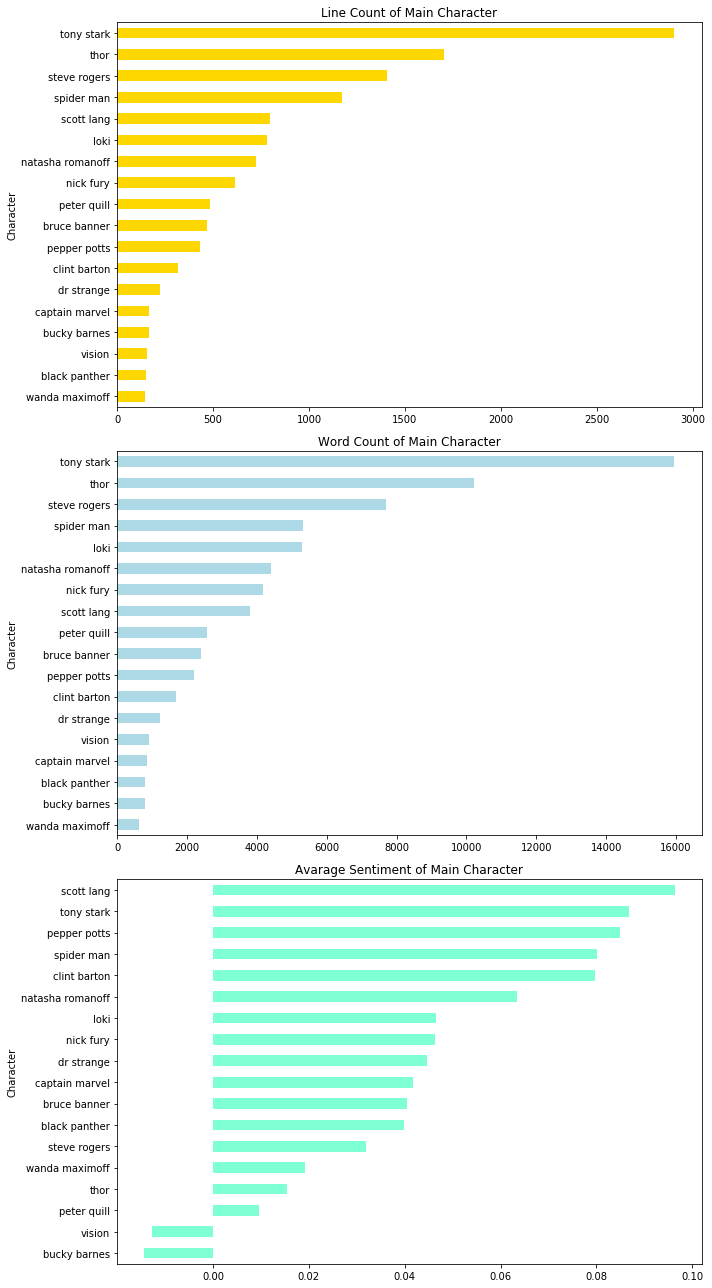

In [9]:
to_plot(cleandf)

tony stark


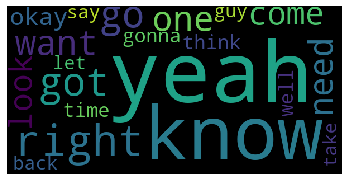

--------------
natasha romanoff


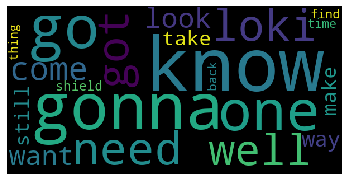

--------------
thor


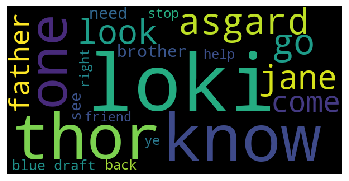

--------------
loki


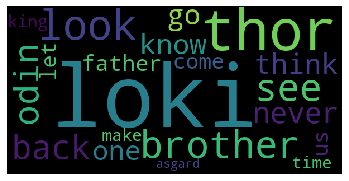

--------------
steve rogers


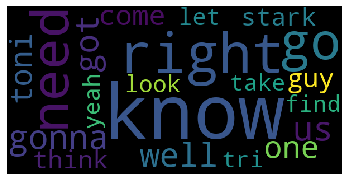

--------------
clint barton


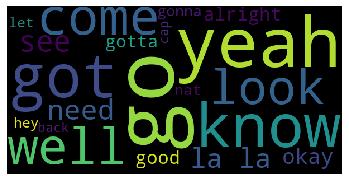

--------------
bruce banner


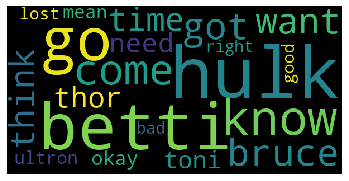

--------------
black panther


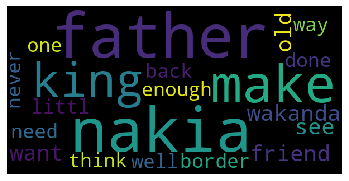

--------------
spider man


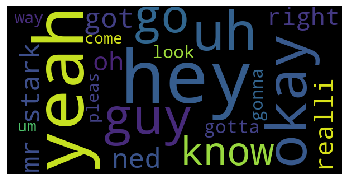

--------------
scott lang


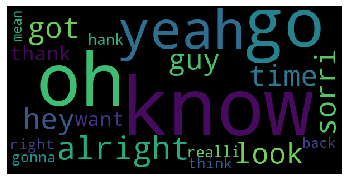

--------------
captain marvel


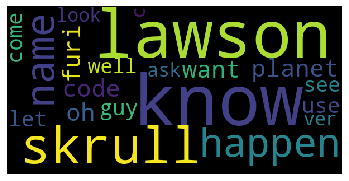

--------------
dr strange


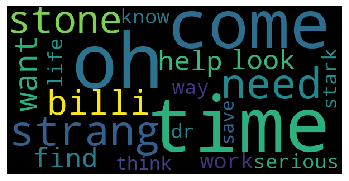

--------------
peter quill


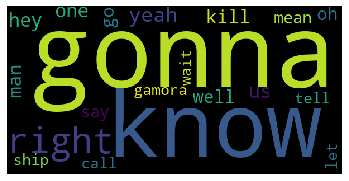

--------------
wanda maximoff


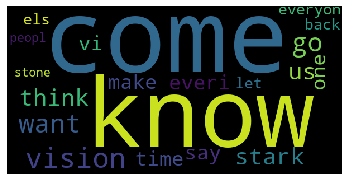

--------------
nick fury


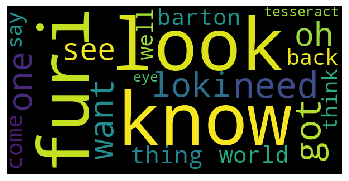

--------------
pepper potts


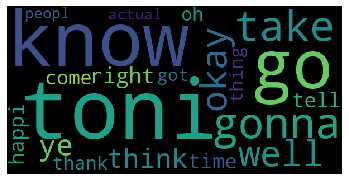

--------------
bucky barnes


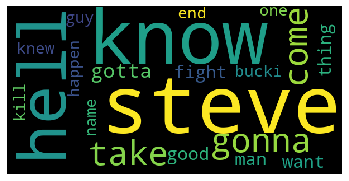

--------------
vision


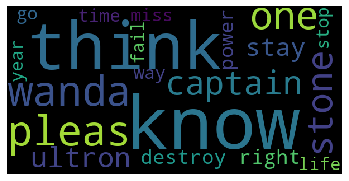

--------------


In [10]:
to_cloud(cleandf, 20)